# Which factors cause Heart Attack?

![](images/kurt.jpeg)

**OVERVIEW**



### Business Understanding

From a business perspective, we are tasked with identifying key drivers for heart attack.Description of Each variable ###Age | Age in years 
Sex | 1 = male; 0 = female 
cp | Chest pain type 
trestbps | Resting blood pressure (in mm Hg on admission to the hospital) 
chol | Serum cholesterol in mg/dl 
fbs | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false) 
restecg | Resting electrocardiographic results 
thalach | Maximum heart rate achieved 
exang | Exercise induced angina (1 = yes; 0 = no) 
oldpeak | ST depression induced by exercise relative to rest 
slope | Slope of the peak exercise ST segment 
ca | Number of major vessels (0-3) colored by fluoroscopy thal | 3 = normal; 6 = fixed defect; 7 = reversible defect 
Target | 1 or 0  

In [63]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel,  RFE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn import set_config
set_config(display="diagram")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Various steps are taken to get to know the dataset and identify any quality issues within.  

In [64]:
filename = '/Users/rajeshgoyal/Desktop/cvd-healthcare-data.csv'
df = pd.read_csv(filename)

In [65]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [67]:
# Dropping any Null values in the data set
df=df.dropna()


In [68]:
#Checking is still there is any null value in the data set
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [69]:
#Checking the Unique values in the dataset
for col in df.columns:
    print('No of Unique values in {} column is {}'.format(col, df[col].nunique()))

No of Unique values in age column is 41
No of Unique values in sex column is 2
No of Unique values in cp column is 4
No of Unique values in trestbps column is 49
No of Unique values in chol column is 152
No of Unique values in fbs column is 2
No of Unique values in restecg column is 3
No of Unique values in thalach column is 91
No of Unique values in exang column is 2
No of Unique values in oldpeak column is 40
No of Unique values in slope column is 3
No of Unique values in ca column is 5
No of Unique values in thal column is 4
No of Unique values in target column is 2


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [70]:
#Dividing the data set into Categorical and Numerical 
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for col in cat_features:
    print('Unique values for {} column: {}'.format(col, df[col].unique()))

Unique values for sex column: [1 0]
Unique values for cp column: [3 2 1 0]
Unique values for fbs column: [1 0]
Unique values for restecg column: [0 1 2]
Unique values for exang column: [0 1]
Unique values for slope column: [0 2 1]
Unique values for ca column: [0 2 1 3 4]
Unique values for thal column: [1 2 3 0]


In [71]:
#Checking if there are any duplications in the data
df[df.duplicated() == True]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [72]:
#Since found duplication in data, dropping the duplication data
df.drop_duplicates(inplace = True)

<Axes: >

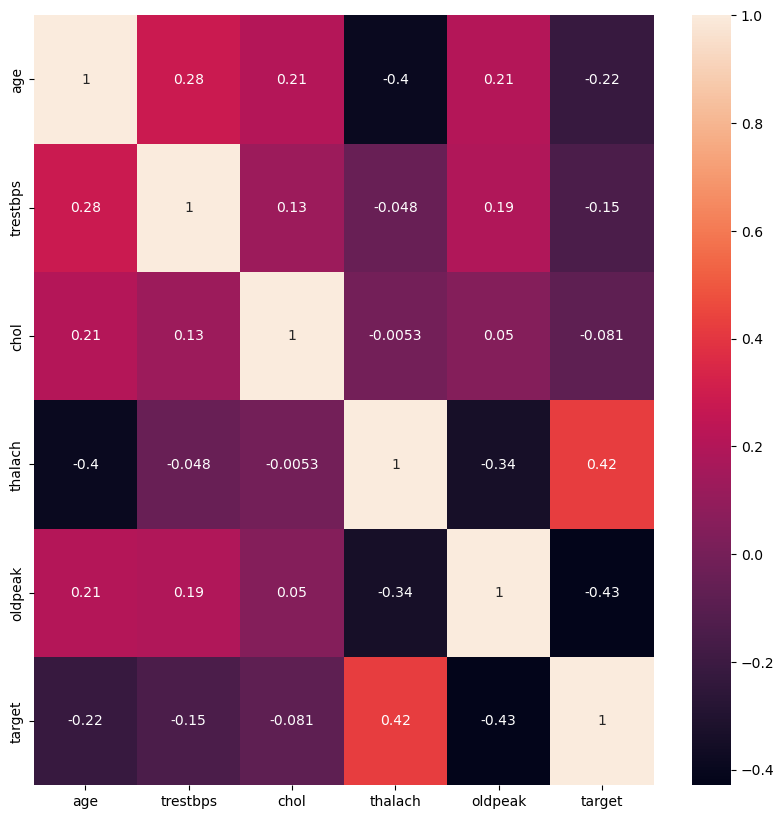

In [73]:
#Creating the heat map to see how the various features are interlinked
plt.figure(figsize=(10,10))
sns.heatmap(df[num_features + ['target']].corr(), annot=True)

<function matplotlib.pyplot.show(close=None, block=None)>

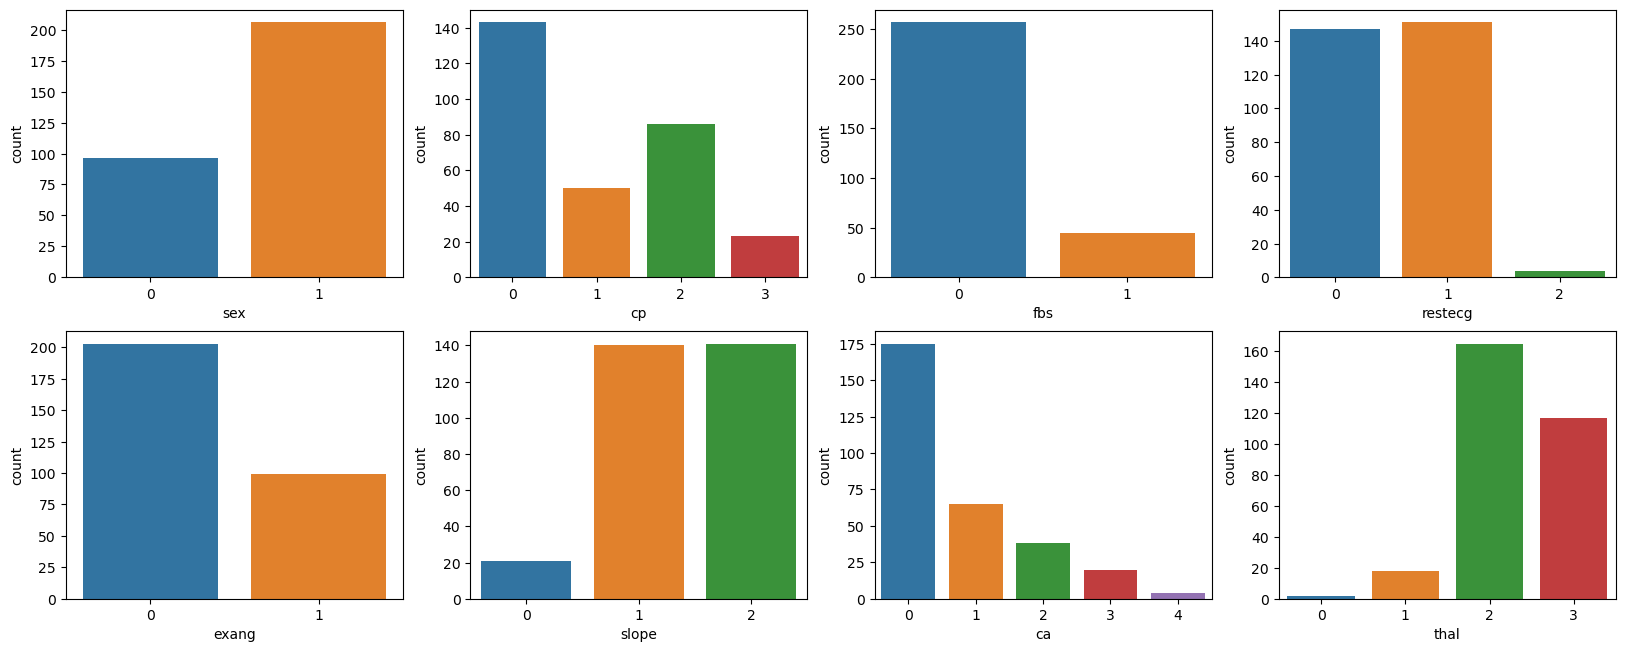

In [74]:
n = 4
plt.figure(figsize=(20,16))
for i, col in enumerate(cat_features):
    plt.subplot(n, n, i+1)
    sns.countplot(x=col, data=df)
plt.show

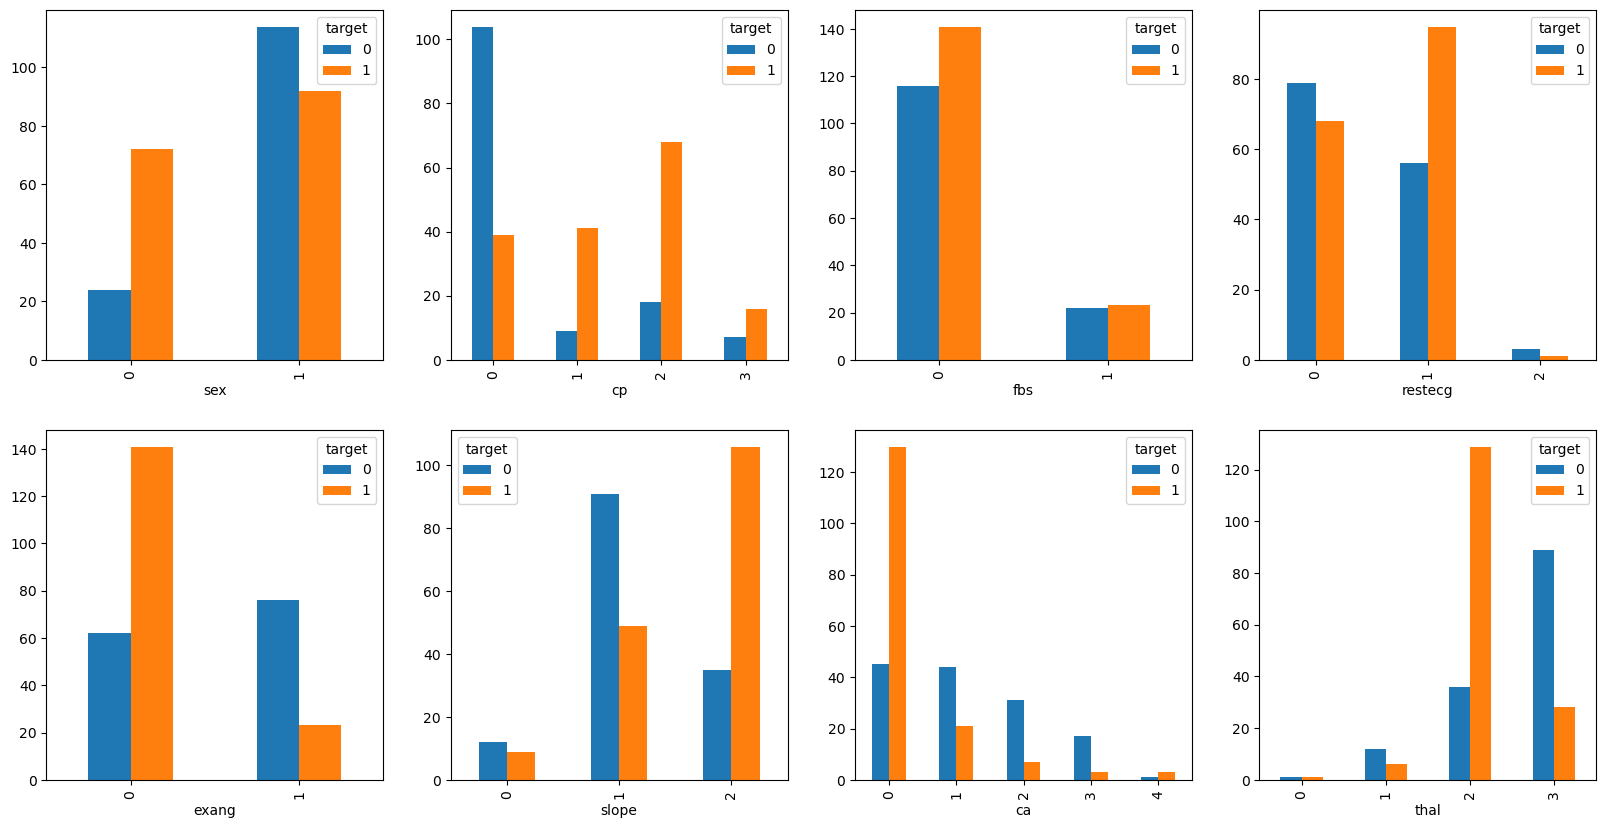

In [75]:
plt.figure(figsize=(20,10))
for i, col in enumerate(cat_features):
    ax = plt.subplot(2,4,i+1)
    pd.crosstab(index=df[col], columns=df['target']).plot(kind='bar', ax=ax)

In [76]:
#Dropping some of the data, which does not have much impact
cols_to_drop = ['age','trestbps','chol', 'fbs', 'restecg']
df2= df.drop(columns=cols_to_drop)
df2

,sex,cp,thalach,exang,oldpeak,slope,ca,thal,target
0,1,3,150,0,2.3,0,0,1,1
1,1,2,187,0,3.5,0,0,2,1
2,0,1,172,0,1.4,2,0,2,1
3,1,1,178,0,0.8,2,0,2,1
4,0,0,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...
298,0,0,123,1,0.2,1,0,3,0
299,1,3,132,0,1.2,1,0,3,0
300,1,0,141,0,3.4,1,2,3,0
301,1,0,115,1,1.2,1,1,3,0


# Creation of Models

In [77]:
X = df2.drop(columns=['target'])
y = df2['target']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.15, random_state=42)

In [78]:
X_train, X_test, y_train, y_test =train_test_split( X, y, test_size=0.3, random_state=22)

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [80]:
# Calculate permutation importances
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
importances = pd.DataFrame(data=perm_importance.importances_mean, index=X_test.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
importances.head(20)


,Importance
oldpeak,0.097520
ca,0.082822
cp,0.079207
thal,0.053630
thalach,0.034679
slope,0.023821
sex,-0.007670
exang,-0.016473


In [81]:
importances.index.unique()

Index(['oldpeak', 'ca', 'cp', 'thal', 'thalach', 'slope', 'sex', 'exang'], dtype='object')

In [82]:
X1=df2[['oldpeak', 'ca', 'cp', 'thal', 'thalach', 'slope', 'sex', 'exang']]
y1 = df2['target']

In [83]:
len(importances)

8

In [84]:
X1_train, X1_test, y1_train, y1_test =train_test_split( X1, y1, test_size=0.3, random_state=22)
y1_train

237    0
262    0
73     1
30     1
86     1
      ..
14     1
146    1
84     1
301    0
132    1
Name: target, Length: 211, dtype: int64

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

# Pipeline model 

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


# Sequential feature selector + Linear regression

In [86]:
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                         ('model', LinearRegression())])
selector_pipe

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression())),
                ('model', LinearRegression())])

In [87]:
param_dict = {'selector__n_features_to_select': [2, 3, 4, 5]}
#param_dict = {}
selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict)
#selector_grid = GridSearchCV(selector_pipe)
selector_grid.fit(X1_train, y1_train)
train_preds = selector_grid.predict(X1_train)
test_preds = selector_grid.predict(X1_test)
selector_train_mse = mean_squared_error(y1_train, train_preds)
selector_test_mse = mean_squared_error(y1_test, test_preds)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {selector_train_mse}')
print(f'Test MSE: {selector_test_mse}')
print(f' R^2 Score::{r2_score(y_true=y1_test, y_pred=test_preds)}')

Train MSE: 0.11840850954507669
Test MSE: 0.179940386135742
 R^2 Score::0.2801515277342612


In [88]:
# Calculate permutation importances
perm_importance = permutation_importance(selector_grid, X1_test, y1_test, n_repeats=30, random_state=42, n_jobs=-1)
importances = pd.DataFrame(data=perm_importance.importances_mean, index=X_test.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
title = "Sequential - Importances and co-efficients"
print(title)
importances.head(10)

Sequential - Importances and co-efficients


,Importance
sex,0.102445
cp,0.095082
thalach,0.094099
exang,0.068891
oldpeak,0.067073
slope,0.000000
ca,0.000000
thal,0.000000


# Ridge Regression

In [89]:
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X1_train, y1_train)
ridge_train_preds = ridge_grid.predict(X1_train)
ridge_test_preds = ridge_grid.predict(X1_test)
ridge_train_mse = mean_squared_error(y1_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y1_test, ridge_test_preds)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')
print(f'Ridge R^2 Score::{r2_score(y_true=y1_test, y_pred=ridge_test_preds)}')
ridge_pipe

Train MSE: 0.11158035477387653
Test MSE: 0.15268658041437275
Ridge R^2 Score::0.38917991670945873


Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

In [90]:
# Calculate permutation importances
perm_importance = permutation_importance(ridge_grid, X1_test, y1_test, n_repeats=30, random_state=42, n_jobs=-1)
importances = pd.DataFrame(data=perm_importance.importances_mean, index=X_test.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
title = "Ridge - Importances and co-efficients"
print(title)
importances.head(10)

Ridge - Importances and co-efficients


,Importance
cp,0.085058
thalach,0.063260
ca,0.054328
sex,0.053596
exang,0.045710
thal,0.039000
oldpeak,0.038350
slope,0.023884


In [91]:
cv = KFold(n_splits=5)
model_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, cv=cv)
scores3 = cross_val_score(model_grid, X1,y1,scoring='neg_mean_squared_error',cv=cv)

In [92]:
cv = KFold(n_splits=5)
model_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, cv=cv)
scores8 = cross_val_score(model_grid, X1,y1,scoring='r2',cv=cv)

In [93]:
print('K-Fold Cross Validation ‘neg_mean_squared_error scores: %s' % scores3)
print('K-Fold Cross Validation ‘neg_mean_squared_error: %.3f +/- %.3f' % (np.mean(scores3),np.std(scores3)))
print('K-Fold Cross Validation r^2 scores: %s' % scores8)
print('K-Fold Cross Validation R^2: %.3f +/- %.3f' % (np.mean(scores8),np.std(scores8)))

K-Fold Cross Validation ‘neg_mean_squared_error scores: [-0.1383347  -0.1795485  -0.13235212 -0.18720564 -0.23465744]
K-Fold Cross Validation ‘neg_mean_squared_error: -0.174 +/- 0.037
K-Fold Cross Validation r^2 scores: [0.         0.         0.36975181 0.         0.        ]
K-Fold Cross Validation R^2: 0.074 +/- 0.148


/Users/rajeshgoyal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Ridge model')

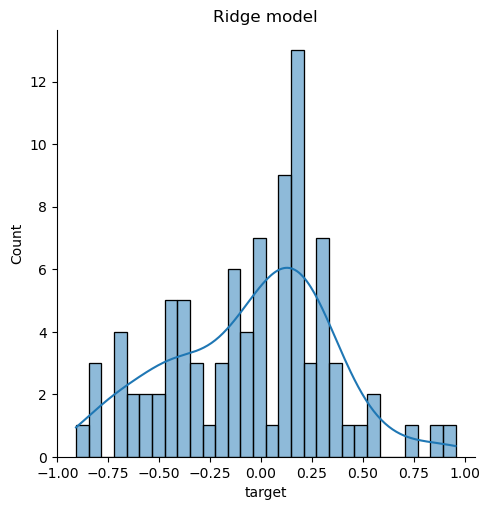

In [94]:
sns.displot(y1_test-ridge_test_preds, bins=30, kde=True)
plt.title("Ridge model")
#plt.savefig('What-Drives-the-Price-of-a-Car/images/Model2_4.png')

# Ordinarily Least Squares (OLS)

In [95]:
ols_pipe = Pipeline([
    ('scaler', StandardScaler()),         # Step for feature scaling
    ('ols', LinearRegression())           # Step for OLS regression
])
ols_pipe

Pipeline(steps=[('scaler', StandardScaler()), ('ols', LinearRegression())])

In [96]:
ols_pipe.fit(X1_train, y1_train)
ols_train_preds = ols_pipe.predict(X1_train)
ols_test_preds = ols_pipe.predict(X1_test)
ols_train_mse = mean_squared_error(y1_train,ols_train_preds)
ols_test_mse = mean_squared_error(y1_test, ols_test_preds)
print(f'OLS Train MSE: {ols_train_mse}')
print(f'OLS Test MSE: {ols_test_mse}')
print(f'OLS Score::{r2_score(y_true=y_test, y_pred=ols_test_preds)}')

OLS Train MSE: 0.11113554553159392
OLS Test MSE: 0.1549254437494939
OLS Score::0.3802233817924837


In [97]:
# Calculate permutation importances
perm_importance = permutation_importance(ols_pipe, X1_test, y1_test, n_repeats=30, random_state=42, n_jobs=-1)
importances = pd.DataFrame(data=perm_importance.importances_mean, index=X_test.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
title = "OLS - Importances and co-efficients"
print(title)
importances.head(10)

OLS - Importances and co-efficients


,Importance
cp,0.088926
thalach,0.066787
ca,0.056700
sex,0.049316
exang,0.046974
oldpeak,0.036388
thal,0.034751
slope,0.024818


In [98]:
cv = KFold(n_splits=5)
#model_grid_lasso = GridSearchCV(selector_pipe_lasso, param_grid=sequential_param_dict)
scores4 = cross_val_score(ols_pipe, X1,y1,scoring='neg_mean_squared_error',cv=cv)

In [99]:
cv = KFold(n_splits=5)
#model_grid_lasso = GridSearchCV(selector_pipe_lasso, param_grid=sequential_param_dict)
scores5 = cross_val_score(ols_pipe, X1,y1,scoring='r2',cv=cv)

In [100]:
print('K-Fold Cross Validation ‘neg_mean_squared_error scores: %s' % scores4)
print('K-Fold Cross Validation ‘neg_mean_squared_error: %.3f +/- %.3f' % (np.mean(scores4),np.std(scores4)))
print('K-Fold Cross Validation r^2 scores: %s' % scores5)
print('K-Fold Cross Validation R^2: %.3f +/- %.3f' % (np.mean(scores5),np.std(scores5)))

K-Fold Cross Validation ‘neg_mean_squared_error scores: [-0.1241825  -0.16026447 -0.13324648 -0.18624395 -0.23458074]
K-Fold Cross Validation ‘neg_mean_squared_error: -0.168 +/- 0.040
K-Fold Cross Validation r^2 scores: [0.         0.         0.36549296 0.         0.        ]
K-Fold Cross Validation R^2: 0.073 +/- 0.146


/Users/rajeshgoyal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'OLS model')

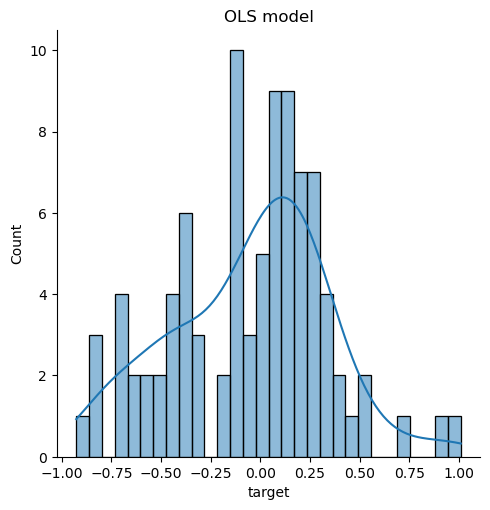

In [101]:
sns.displot(y1_test-ols_test_preds, bins=30, kde=True)
plt.title("OLS model")

#plt.savefig('What-Drives-the-Price-of-a-Car/images/Model2_4.png')

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [102]:
mse_11 = pd.DataFrame([('Ridge', 0.152),
                   ('SEQ', 0.179),
                   ('OLS', 0.159)],
           columns=('Model','MSE')
                 )

In [103]:
plotdata1 = pd.DataFrame(
    {"MSE": [0.152, 0.179, 0.159]}, 
    index=["Ridge", "SEQ", "OLS"])

(array([0, 1, 2]), [Text(0, 0, 'Ridge'), Text(1, 0, 'SEQ'), Text(2, 0, 'OLS')])

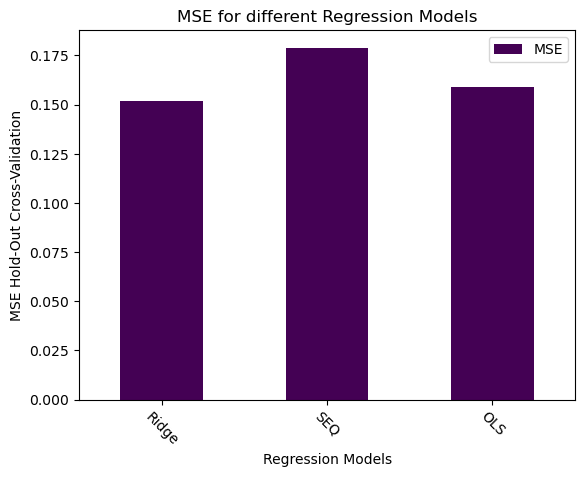

In [104]:
plotdata1.plot(kind="bar",stacked=True,colormap='viridis')
plt.title("MSE for different Regression Models")
plt.xlabel("Regression Models")
plt.ylabel("MSE Hold-Out Cross-Validation")
plt.xticks(rotation=-45)


In [105]:
plotdata3 = pd.DataFrame(
    {"R^2 Score": [0.389, 0.280,0.380]}, 
    index=["Ridge", "SEQ","OLS"])

(array([0, 1, 2]), [Text(0, 0, 'Ridge'), Text(1, 0, 'SEQ'), Text(2, 0, 'OLS')])

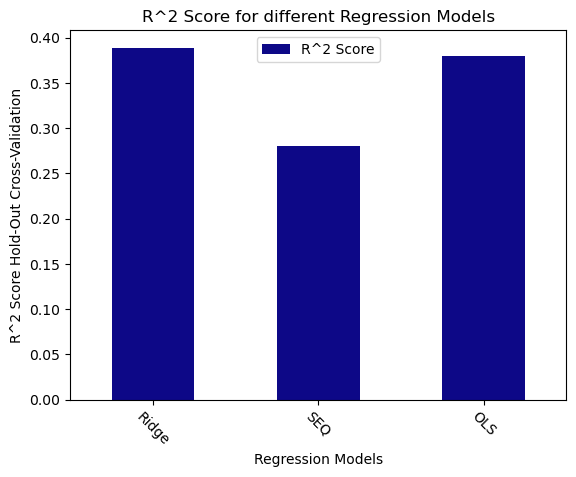

In [106]:
plotdata3.plot(kind="bar",stacked=True,colormap='plasma')
plt.title("R^2 Score for different Regression Models")
plt.xlabel("Regression Models")
plt.ylabel("R^2 Score Hold-Out Cross-Validation")
plt.legend(loc='upper center')
plt.xticks(rotation=-45)


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.